
# Masar Data Validation & QA — Notebook

This notebook runs **strict validation tests** and produces **sanity-check charts** for Masar generated datasets (day / week / month).
It is designed to work directly in Colab or Jupyter against files in `masar-sim/data/generated/`.

**What it checks:**
- File presence & schema conformance
- Nulls / NaNs / dtypes
- Logical constraints (e.g., `station_total <= capacity * 1.1`)
- Event flags mapping (`special_event_type` vs. calendar)
- Headway ranges and peak/off-peak sanity
- Aggregations by day/station
- Distribution charts and sample time series

> Charts are rendered with matplotlib (no style/colors specified), one chart per cell.


In [ ]:
!ls -R /content/2025_GP_28/masar-sim/sims


ls: cannot access '/content/2025_GP_28/masar-sim/sims': No such file or directory


In [ ]:
!ls -R /content/2025_GP_28/masar-sim | grep -i sim


/content/2025_GP_28/masar-sim:
/content/2025_GP_28/masar-sim/2025_GP_28:
masar-sim
/content/2025_GP_28/masar-sim/2025_GP_28/android:
/content/2025_GP_28/masar-sim/2025_GP_28/android/app:
/content/2025_GP_28/masar-sim/2025_GP_28/android/app/src:
/content/2025_GP_28/masar-sim/2025_GP_28/android/app/src/debug:
/content/2025_GP_28/masar-sim/2025_GP_28/android/app/src/main:
/content/2025_GP_28/masar-sim/2025_GP_28/android/app/src/main/kotlin:
/content/2025_GP_28/masar-sim/2025_GP_28/android/app/src/main/kotlin/com:
/content/2025_GP_28/masar-sim/2025_GP_28/android/app/src/main/kotlin/com/example:
/content/2025_GP_28/masar-sim/2025_GP_28/android/app/src/main/kotlin/com/example/flutter_application_1:
/content/2025_GP_28/masar-sim/2025_GP_28/android/app/src/main/res:
/content/2025_GP_28/masar-sim/2025_GP_28/android/app/src/main/res/drawable:
/content/2025_GP_28/masar-sim/2025_GP_28/android/app/src/main/res/drawable-v21:
/content/2025_GP_28/masar-sim/2025_GP_28/android/app/src/main/res/mipmap-hd

In [ ]:
%cd /content
!git clone https://github.com/Jana-Alrzoog/2025_GP_28.git
%cd /content/2025_GP_28/masar-sim
!ls

/content
fatal: destination path '2025_GP_28' already exists and is not an empty directory.
/content/2025_GP_28/masar-sim
2025_GP_28  data


In [ ]:
%cd /content
!git clone https://github.com/Jana-Alrzoog/2025_GP_28.git
%cd /content/2025_GP_28/masar-sim
!ls

/content
fatal: destination path '2025_GP_28' already exists and is not an empty directory.
/content/2025_GP_28/masar-sim
2025_GP_28  data


In [ ]:
!ls -R /content/2025_GP_28/masar-sim/sims


ls: cannot access '/content/2025_GP_28/masar-sim/sims': No such file or directory


In [ ]:
# Auto-resolve ROOT/SEED/GEN/CONF even if repo is nested
import os, glob, yaml
from pathlib import Path

hits = glob.glob("/content/**/masar-sim/sims/00_config.yaml", recursive=True) \
     or glob.glob("/content/**/masar-sim/sims/00_config.yml", recursive=True)

if not hits:
    raise FileNotFoundError("Couldn't find sims/00_config.yaml anywhere under /content/**/masar-sim")

CONF_PATH = Path(hits[0]).resolve()
ROOT_PATH = CONF_PATH.parent.parent.resolve()
SEED_PATH = ROOT_PATH / "data" / "seeds"
GEN_PATH  = ROOT_PATH / "data" / "generated"

# print roots to make sure
print("ROOT =", ROOT_PATH)
print("SEED =", SEED_PATH)
print("GEN  =", GEN_PATH)
print("CONF =", CONF_PATH)


GEN_PATH.mkdir(parents=True, exist_ok=True)


with open(CONF_PATH, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f) or {}

print("✅ Config loaded. Keys:", list(config.keys())[:10])


SHORT = Path("/content/masar-sim")
if not SHORT.exists():
    try:
        SHORT.symlink_to(ROOT_PATH, target_is_directory=True)
        print("🔗 Symlink created:", SHORT, "→", ROOT_PATH)
    except Exception as e:
        print("Symlink skipped:", e)


ROOT = /content/2025_GP_28/masar-sim/2025_GP_28/masar-sim
SEED = /content/2025_GP_28/masar-sim/2025_GP_28/masar-sim/data/seeds
GEN  = /content/2025_GP_28/masar-sim/2025_GP_28/masar-sim/data/generated
CONF = /content/2025_GP_28/masar-sim/2025_GP_28/masar-sim/sims/00_config.yaml
✅ Config loaded. Keys: ['start_date', 'tz', 'minute_resolution', 'date_range', 'output_partitioning', 'random_seed', 'operation', 'peaks', 'headway', 'capacity']
🔗 Symlink created: /content/masar-sim → /content/2025_GP_28/masar-sim/2025_GP_28/masar-sim


In [ ]:
# Robust discovery and load
import os, glob, pandas as pd

gen_candidates = sorted(glob.glob("/content/**/masar-sim/**/data/generated", recursive=True))
assert gen_candidates, "لم أجد أي مجلد data/generated تحت /content/**/masar-sim"

print("Found GEN dirs:")
for g in gen_candidates: print(" -", g)

def pick_gen(cands):
    for g in cands:
        if (glob.glob(g+"/cf_month_*.csv") or glob.glob(g+"/month_*.csv") or
            glob.glob(g+"/cf_week_*.csv")  or glob.glob(g+"/week_*.csv")  or
            glob.glob(g+"/cf_day_*.csv")   or glob.glob(g+"/day_*.csv")):
            return g
    return cands[0]

GEN = pick_gen(gen_candidates)
print("\nUsing GEN:", GEN)

def latest_any(*pats):
    files=[]
    for p in pats: files += glob.glob(p)
    return max(files, key=os.path.getmtime) if files else None

MONTH_FILE = latest_any(f"{GEN}/cf_month_*.csv", f"{GEN}/month_*.csv")
WEEK_FILE  = latest_any(f"{GEN}/cf_week_*.csv",  f"{GEN}/week_*.csv")
DAY_FILE   = latest_any(f"{GEN}/cf_day_*.csv",   f"{GEN}/day_*.csv")


if os.path.exists(f"{GEN}/month_2025-09.csv"):
    MONTH_FILE = f"{GEN}/month_2025-09.csv"
if os.path.exists(f"{GEN}/week_2025-09-21_to_27.csv"):
    WEEK_FILE = f"{GEN}/week_2025-09-21_to_27.csv"

print("\nDetected files:")
print("  DAY  :", DAY_FILE)
print("  WEEK :", WEEK_FILE)
print("  MONTH:", MONTH_FILE)

def safe_read_csv(path):
    if path and os.path.exists(path):
        df = pd.read_csv(path)
        print(f"Loaded ✓ {os.path.basename(path)} | rows={len(df):,}")
        return df
    print("Skip (not found):", path); return None

month_df = safe_read_csv(MONTH_FILE)
week_df  = safe_read_csv(WEEK_FILE)
day_df   = safe_read_csv(DAY_FILE)

cands = [x for x in [month_df, week_df, day_df] if x is not None]
assert cands, f"ما فيه CSVs مولّدة في: {GEN} — تأكدّي إن مولّد اليوم/الأسبوع/الشهر اشتغل."
df = max(cands, key=lambda x: len(x))
print("Using dataframe with rows =", len(df))


Found GEN dirs:
 - /content/2025_GP_28/masar-sim/2025_GP_28/masar-sim/data/generated
 - /content/2025_GP_28/masar-sim/2025_GP_28/masar-sim/data/generated
 - /content/2025_GP_28/masar-sim/data/generated
 - /content/masar-sim/data/generated

Using GEN: /content/2025_GP_28/masar-sim/2025_GP_28/masar-sim/data/generated

Detected files:
  DAY  : /content/2025_GP_28/masar-sim/2025_GP_28/masar-sim/data/generated/cf_day_2025-09-24.csv
  WEEK : /content/2025_GP_28/masar-sim/2025_GP_28/masar-sim/data/generated/week_2025-09-21_to_27.csv
  MONTH: /content/2025_GP_28/masar-sim/2025_GP_28/masar-sim/data/generated/month_2025-09.csv


/tmp/ipython-input-2494795477.py:47: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Loaded ✓ month_2025-09.csv | rows=194,580
Loaded ✓ week_2025-09-21_to_27.csv | rows=45,402
Loaded ✓ cf_day_2025-09-24.csv | rows=6,480
Using dataframe with rows = 194580


/tmp/ipython-input-2494795477.py:47: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


## 🔎 Schema & Null Checks

In [ ]:

required_cols = [
    "date","timestamp","hour","minute_of_day","day_of_week","is_weekend",
    "station_id","base_demand","modifier","demand_final",
    "station_total","crowd_level","special_event_type","event_flag","holiday_flag","headway_seconds"
]
missing = [c for c in required_cols if c not in df.columns]
print("Missing columns:", missing)
assert not missing, f"Schema error — missing columns: {missing}"

# Dtype coercions (won't fail if non-numeric but will show counts)
num_cols = ["hour","minute_of_day","day_of_week","is_weekend",
            "base_demand","modifier","demand_final","station_total","event_flag","holiday_flag","headway_seconds"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Null checks
null_counts = df[required_cols].isna().sum().sort_values(ascending=False)
print("Null counts (top):\n", null_counts.head(10))

# Basic ranges
assert (df["minute_of_day"].between(0, 1439) | df["minute_of_day"].isna()).all(), "minute_of_day out of bounds"
assert df["hour"].between(0, 23).all(), "hour out of bounds"
assert df["day_of_week"].between(0, 6).all(), "day_of_week out of bounds"
print("Schema & basic ranges ✓")


Missing columns: []
Null counts (top):
 special_event_type    182689
date                       0
hour                       0
timestamp                  0
day_of_week                0
is_weekend                 0
station_id                 0
minute_of_day              0
base_demand                0
modifier                   0
dtype: int64
Schema & basic ranges ✓


## Capacity & Logical Constraints

In [ ]:
# to merge capacities safely
import numpy as np
import pandas as pd
import json, glob
from pathlib import Path

# locate stations.json
paths = glob.glob("/content/**/masar-sim/**/data/seeds/stations.json", recursive=True)
assert paths, "Couldn't find stations.json under any masar-sim/**/data/seeds"
STATIONS_PATH = Path(paths[0]).resolve()
print("Found stations.json at:", STATIONS_PATH)

# load capacities from seed
with open(STATIONS_PATH, "r", encoding="utf-8") as f:
    stations = json.load(f)

cap = pd.DataFrame(stations)[["station_id", "capacity_station"]].copy()
cap["capacity_station"] = pd.to_numeric(cap["capacity_station"], errors="coerce")

# merge logic:
if "capacity_station" in df.columns:
    # to keep existing column
    df = df.merge(
        cap.rename(columns={"capacity_station": "capacity_from_seed"}),
        on="station_id",
        how="left"
    )
    df["capacity_station"] = pd.to_numeric(df["capacity_station"], errors="coerce")
    df["capacity_from_seed"] = pd.to_numeric(df["capacity_from_seed"], errors="coerce")

    # prefer existing positive values; otherwise use seed
    df["capacity_station"] = np.where(
        (df["capacity_station"].isna()) | (df["capacity_station"] <= 0),
        df["capacity_from_seed"],
        df["capacity_station"]
    )
    df.drop(columns=["capacity_from_seed"], inplace=True)
else:
    # no conflict — simple merge
    df = df.merge(cap, on="station_id", how="left")

# final sanitation
df["capacity_station"] = pd.to_numeric(df["capacity_station"], errors="coerce").fillna(0)

assert (df["station_total"] >= 0).all(), "Negative station_total found"
over = df[df["station_total"] > (df["capacity_station"] * 1.10 + 1)]
print("Rows exceeding 110% capacity:", len(over))


Found stations.json at: /content/2025_GP_28/masar-sim/2025_GP_28/masar-sim/data/seeds/stations.json
Rows exceeding 110% capacity: 0


##  Event Flags / Types Sanity

In [ ]:

# Inspect mapping of special_event_type and event_flag
etype_counts = df["special_event_type"].fillna("None").value_counts().head(20)
print("Top special_event_type values:\n", etype_counts)

# here if event_flag==0 then special_event_type should be None
mismatch = df[(df["event_flag"]==0) & (df["special_event_type"].fillna("None")!="None")]
print("event_flag=0 but special_event_type!=None:", len(mismatch))
if len(mismatch) > 0:
    display(mismatch.head(10))

# Opposite check
mismatch2 = df[(df["event_flag"]==1) & (df["special_event_type"].fillna("None")=="None")]
print("event_flag=1 but special_event_type==None:", len(mismatch2))
if len(mismatch2) > 0:
    display(mismatch2.head(10))

print("Event flag sanity ✓")


Top special_event_type values:
 special_event_type
None               182689
NationalHoliday      6486
Festival             3243
Sports               2162
Name: count, dtype: int64
event_flag=0 but special_event_type!=None: 0
event_flag=1 but special_event_type==None: 0
Event flag sanity ✓


##  Headway Sanity

In [ ]:

# Reasonable headway bounds in seconds
# Adjust bounds if config differs widely
min_hw, max_hw = 60*3, 60*20  # 3 to 20 minutes
out_of_bounds = df[(df["headway_seconds"] < min_hw) | (df["headway_seconds"] > max_hw)]
print("Headways out of [3,20] minutes:", len(out_of_bounds))
if len(out_of_bounds) > 0:
    display(out_of_bounds.head(10))

print("Headway sanity ✓")


Headways out of [3,20] minutes: 0
Headway sanity ✓


##  Aggregations & Distributions

,date,daily_peak_load,daily_avg_load
0,9/1/2025,30555,7921.672525
1,9/10/2025,34359,8907.643848
2,9/11/2025,30555,7921.672525
3,9/12/2025,27500,7129.651249
4,9/13/2025,27500,7129.651249
5,9/14/2025,30555,7921.672525
6,9/15/2025,30555,7921.672525
7,9/16/2025,30555,7921.672525
8,9/17/2025,37128,9625.337650
9,9/18/2025,30555,7921.672525


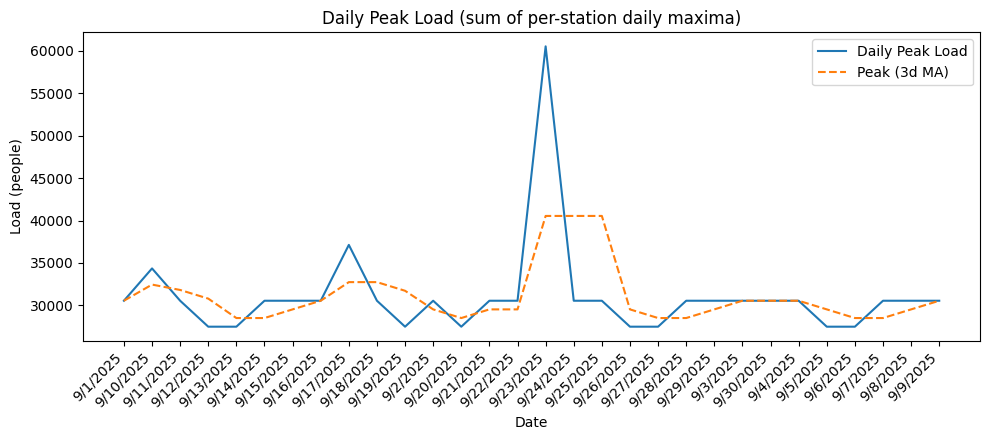

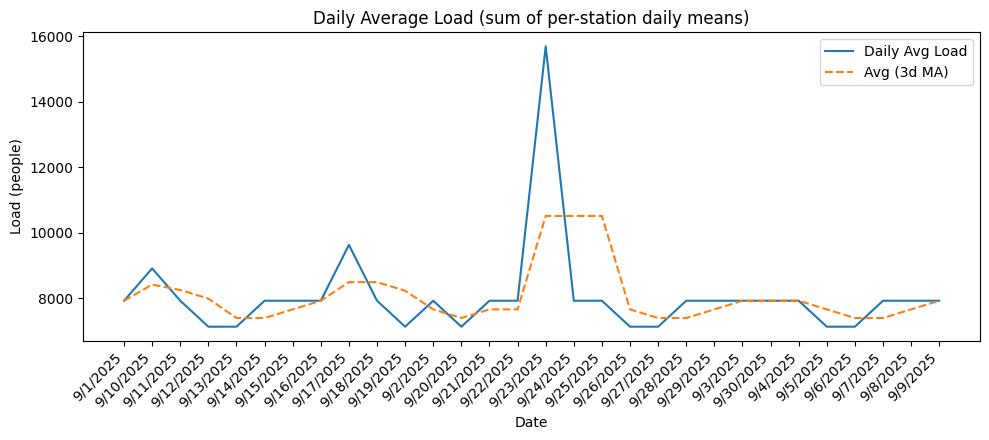

In [ ]:
#Reasonable daily KPIs from minute-level station_total
#Per-day and per-station take max and mean across minutes
per_station_day = (
    df.groupby(["date", "station_id"], as_index=False)
      .agg(
          max_per_min=("station_total", "max"),
          mean_per_min=("station_total", "mean"),
      )
)

# Aggregate to per-day KPIs
daily_kpis = (
    per_station_day.groupby("date", as_index=False)
                   .agg(
                       daily_peak_load=("max_per_min", "sum"),
                       daily_avg_load=("mean_per_min", "sum"),
                   )
                   .sort_values("date")
                   .reset_index(drop=True)
)

display(daily_kpis.head(15))


daily_kpis["peak_roll3"] = daily_kpis["daily_peak_load"].rolling(3, min_periods=1).mean()
daily_kpis["avg_roll3"]  = daily_kpis["daily_avg_load"].rolling(3, min_periods=1).mean()

# Line chart for peak and average loads per day
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4.5))
plt.plot(daily_kpis["date"], daily_kpis["daily_peak_load"], label="Daily Peak Load")
plt.plot(daily_kpis["date"], daily_kpis["peak_roll3"], linestyle="--", label="Peak (3d MA)")
plt.xticks(rotation=45, ha="right")
plt.title("Daily Peak Load (sum of per-station daily maxima)")
plt.xlabel("Date"); plt.ylabel("Load (people)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4.5))
plt.plot(daily_kpis["date"], daily_kpis["daily_avg_load"], label="Daily Avg Load")
plt.plot(daily_kpis["date"], daily_kpis["avg_roll3"], linestyle="--", label="Avg (3d MA)")
plt.xticks(rotation=45, ha="right")
plt.title("Daily Average Load (sum of per-station daily means)")
plt.xlabel("Date"); plt.ylabel("Load (people)")
plt.legend()
plt.tight_layout()
plt.show()


##  Sample Time Series

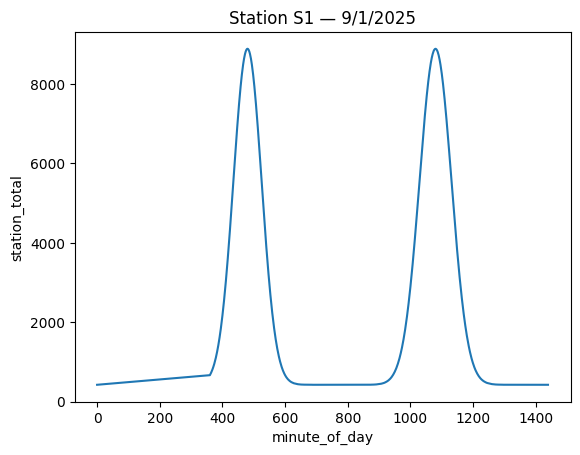

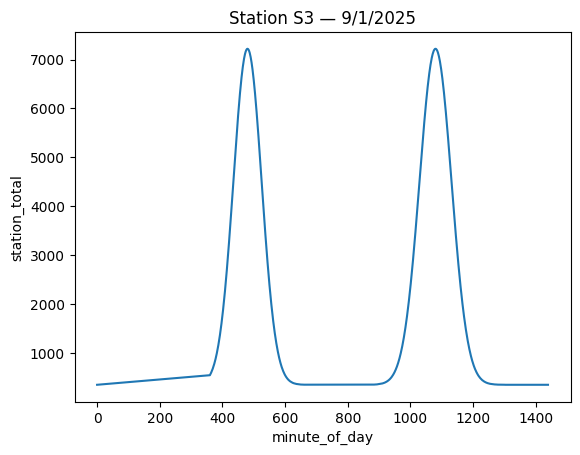

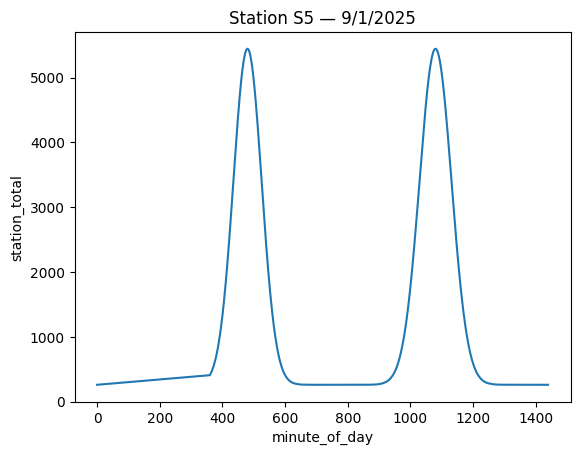

In [ ]:

# Choose sample station  prefer known large ones if present, otherwise top by capacity
pref = ["KAFD", "QASR", "AIRP_T12", "MUSEUM", "S6"]
sid_map = {str(s.get("code","")).upper(): str(s.get("station_id","")) for s in stations}
preferred_sids = [sid_map.get(p) for p in pref if sid_map.get(p)]
if not preferred_sids:
    preferred_sids = list(agg_station.head(3)["station_id"])

for sid in preferred_sids[:3]:
    tmp = df[df["station_id"]==sid].copy()
    if tmp.empty:
        continue
    # one day plot for first date available
    d0 = tmp["date"].iloc[0]
    one = tmp[tmp["date"]==d0].sort_values("minute_of_day")
    plt.figure()
    plt.plot(one["minute_of_day"], one["station_total"])
    plt.title(f"Station {sid} — {d0}")
    plt.xlabel("minute_of_day")
    plt.ylabel("station_total")
    plt.show()


##  Final Assertions Summary

In [ ]:

issues = []

# station_total
viol = df["station_total"] > (df["capacity_station"]*1.10 + 1)
if viol.any():
    n = int(viol.sum())
    issues.append(f"Capacity exceedances: {n} rows")

# No negative values
if (df["station_total"] < 0).any():
    issues.append("Negative station_total values found")
if (df["demand_final"] < 0).any():
    issues.append("Negative demand_final values found")

# event_flag vs type
bad1 = ((df["event_flag"]==0) & (df["special_event_type"].fillna("None")!="None")).sum()
bad2 = ((df["event_flag"]==1) & (df["special_event_type"].fillna("None")=="None")).sum()
if bad1: issues.append(f"Inconsistent event flags (flag=0,type!=None): {bad1}")
if bad2: issues.append(f"Inconsistent event flags (flag=1,type=None): {bad2}")

# headway bounds
min_hw, max_hw = 60*3, 60*20
oob = ((df["headway_seconds"] < min_hw) | (df["headway_seconds"] > max_hw)).sum()
if oob: issues.append(f"Headways out of bounds [180,1200] sec: {oob}")

if issues:
    print("❌ Issues found:")
    for i in issues:
        print(" -", i)
else:
    print("✅ All checks passed with current thresholds.")


✅ All checks passed with current thresholds.
